# Check implementation of Wajima-Hartmann model

In [1]:
import os

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
sns.set_theme()

from model import (
    define_wajima_model,
    define_hartmann_population_model)

## Define Wajima model

In [2]:
mechanistic_model, parameters_df = define_wajima_model()

## Reproduce Figure 2 in Wajima et al (2009)
Time course of coagulation factors and integral of fibrin during PT test
and aPPT test.

For details on the tests, see documentation.

### 1. Prothrombin test

In [3]:
# Prepare model for test
outputs = [
    'central.coagulation_factor_ii_concentration',
    'central.activated_coagulation_factor_ii_concentration',
    'central.coagulation_factor_x_concentration',
    'central.activated_coagulation_factor_x_concentration',
    'central.fibrinogen_concentration',
    'central.fibrin_concentration']
mechanistic_model.set_outputs(outputs)
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in mechanistic_model.parameters()
])

# Dilute the plasma sample
n_states = mechanistic_model._n_states
parameters[:n_states] /= 3

# Set thrombomodulin concentration to zero
parameter_names = np.array(mechanistic_model.parameters())
index = np.where(parameter_names == 'central.thrombomodulin_amount')[0]
parameters[index] = 0

# Set endogenous production rates to zero
index = np.where(parameter_names == 'myokit.input_rate_vk')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_fibrinogen')[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.production_rate_plasminogen')[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.production_rate_prekrallikrein')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_tfpi')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_tmod')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_v')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_viii')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_xi')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_xii')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_xiii')[0]
parameters[index] = 0

# Make sure that only compounds in central compartment are considered
index = np.where(parameter_names == 'dose.drug_amount')[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'peripheral_vitamin_k.vitamin_k_peripheral_amount'
)[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.transition_rate_vk_central_to_peripheral'
)[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.transition_rate_vk_peripheral_to_central'
)[0]
parameters[index] = 0

# Change time units to seconds (for numerical stability)
indices = []
for idp, name in enumerate(parameter_names):
    if 'rate' in name:
        indices.append(idp)
parameters[indices] /= 60 * 60

# Add 300 nM tissue factor
index = np.where(parameter_names == 'central.size')[0]
volume = parameters[index]
index = np.where(parameter_names == 'central.tissue_factor_amount')[0]
parameters[index] = 300 * volume

# Ensure excess of coagulation factor VII (set to 10 nM)
index = np.where(
    parameter_names == 'central.caogaulation_factor_vii_amount')[0]
parameters[index] = 10 * volume

# Integrate fibrin concentration curve
times = np.linspace(start=0, stop=90, num=1000)
delta_time = (times[1] - times[0])
simulation = mechanistic_model.simulate(parameters, times)
fibrin_auc = np.cumsum(simulation[-1] * delta_time)

Visualise results

In [4]:
# Figure 1: Change of coagulation factors
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[0] / simulation[0, 0],
    name='Prothrombin'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[1] / simulation[0, 0],
    name='Thrombin'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[2] / simulation[2, 0],
    name='Coag. factor X'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[3] / simulation[2, 0],
    name='Act. coag. factor X'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[4] / simulation[4, 0],
    name='Fibrinogen'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[5] / simulation[4, 0],
    name='Fibrin'
))
fig.update_layout(
    xaxis_title='Time in seconds',
    yaxis_title=r'% of initial inactivated concentration',
    yaxis_range=[0, 1]
)
fig.show()

# Figure 2: Fibrin integral
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times,
    y=fibrin_auc,
))
fig.add_shape(type="line",
    x0=0, y0=1500, x1=11.75, y1=1500,
    line=dict(
        color="red",
        width=2,
        dash="dash"
    )
)
fig.add_shape(type="line",
    x0=11.75, y0=-1, x1=11.75, y1=1500,
    line=dict(
        color="red",
        width=2,
        dash="dash",
    )
)
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Integral of fibrin in nMs',
    yaxis_type='log',
    yaxis_range=[-1, 6]
)
fig.show()

### 2. aPPT test (not relevant for this study, but useful as a implementation check)

In [5]:
# Prepare model for test
outputs = [
    'central.coagulation_factor_ii_concentration',
    'central.activated_coagulation_factor_ii_concentration',
    'central.coagulation_factor_x_concentration',
    'central.activated_coagulation_factor_x_concentration',
    'central.fibrinogen_concentration',
    'central.fibrin_concentration']
mechanistic_model.set_outputs(outputs)
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in mechanistic_model.parameters()
])

# Dilute the plasma sample
n_states = mechanistic_model._n_states
parameters[:n_states] /= 3

# Set thrombomodulin concentration to zero
parameter_names = np.array(mechanistic_model.parameters())
index = np.where(parameter_names == 'central.thrombomodulin_amount')[0]
parameters[index] = 0

# Update coagulation factor (a)XI concentrations
index = np.where(parameter_names == 'central.size')[0]
volume = parameters[index]
index = np.where(
    parameter_names == 'central.coagulation_factor_xi_amount')[0]
initial_xi_conc = parameters[index]
parameters[index] = initial_xi_conc * 0.339
index = np.where(
    parameter_names == 'central.activated_coagulation_factor_xi_amount')[0]
parameters[index] = initial_xi_conc * 0.148

# Set endogenous production rates to zero
index = np.where(parameter_names == 'myokit.input_rate_vk')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_fibrinogen')[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.production_rate_plasminogen')[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.production_rate_prekrallikrein')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_tfpi')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_tmod')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_v')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_viii')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_xi')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_xii')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_xiii')[0]
parameters[index] = 0

# Make sure that only compounds in central compartment are considered
index = np.where(parameter_names == 'dose.drug_amount')[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'peripheral_vitamin_k.vitamin_k_peripheral_amount'
)[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.transition_rate_vk_central_to_peripheral'
)[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.transition_rate_vk_peripheral_to_central'
)[0]
parameters[index] = 0

# Change time units to seconds (for numerical stability)
indices = []
for idp, name in enumerate(parameter_names):
    if 'rate' in name:
        indices.append(idp)
parameters[indices] /= 60 * 60

# Add 300 nM contact activator
index = np.where(
    parameter_names == 'central.contact_system_activator_amount')[0]
parameters[index] = 300 * volume

# Integrate fibrin concentration curve
times = np.linspace(start=0, stop=90, num=1000)
delta_time = (times[1] - times[0])
simulation = mechanistic_model.simulate(parameters, times)
fibrin_auc = np.cumsum(simulation[-1] * delta_time)

Visualise results

In [6]:
# Visualise results
# Figure 1: Change of coagulation factors
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[0] / simulation[0, 0],
    name='Prothrombin'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[1] / simulation[0, 0],
    name='Thrombin'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[2] / simulation[2, 0],
    name='Coag. factor X'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[3] / simulation[2, 0],
    name='Act. coag. factor X'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[4] / simulation[4, 0],
    name='Fibrinogen'
))
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[5] / simulation[4, 0],
    name='Fibrin'
))
fig.update_layout(
    xaxis_title='Time in seconds',
    yaxis_title=r'% of initial inactivated concentration',
    yaxis_range=[0, 1]
)
fig.show()

# Figure 2: Fibrin integral
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times,
    y=fibrin_auc,
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Integral of fibrin in nMs',
    yaxis_type='log',
    yaxis_range=[-1, 6]
)
fig.show()

## Reproduce Figure 3 in Wajima et al (2009)

Treatment response to daily 4 mg warfarin dose.

In [7]:
# Define outputs and dosing regimen
outputs_of_interest = [
    'central_warfarin.warfarin_concentration',
    'central.vitamin_k_concentration',
    'central.vitamin_k_hydroquinone_concentration',
    'central.vitamin_k_epoxide_concentration',
    'central.coagulation_factor_ii_concentration',
    'central.coagulation_factor_vii_concentration',
    'central.coagulation_factor_ix_concentration',
    'central.coagulation_factor_x_concentration']
n_states = mechanistic_model._n_states
plasma_sample_states = mechanistic_model.parameters()[:n_states]
mechanistic_model.set_outputs(outputs_of_interest + plasma_sample_states)
mechanistic_model.set_dosing_regimen(dose=4, start=0, period=24, num=20)

# Simulate treatment response over a period of 25 days
times = np.linspace(start=0, stop=24 * 20, num=1000)
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in mechanistic_model.parameters()
])
simulation = mechanistic_model.simulate(parameters=parameters, times=times)

# Perform coagulation test for each plasma sample
inr_test_model, _ = define_wajima_model(patient=True, inr_test=True)
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in inr_test_model.parameters()
])

prothrombin_time = np.empty(shape=len(times))
for ids, plasma_sample in enumerate(simulation[len(outputs_of_interest):].T):
    prothrombin_time[ids] = inr_test_model.compute_prothrombin_time(
        plasma_sample, parameters)

# Standardise PT to INR
prothrombin_time = prothrombin_time / prothrombin_time[0]

# Convert time unit to days
times /= 24

Visualise results

In [8]:
# Figure 1: Warfarin concentration
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[0],
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Warfarin concentration in mg/L',
    yaxis_range=[0, 1]
)
fig.show()

# Figure 2: Vitamin K related compounds
fig = go.Figure()
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in mechanistic_model.parameters()
])
parameter_names = np.array(mechanistic_model.parameters())
index_amount = np.where(parameter_names == 'central.vitamin_k_amount')[0]
index_v = np.where(parameter_names == 'central.size')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[1] / initial_conc * 100,
    name='Vitamin K'
))
index_amount = np.where(
    parameter_names == 'central.vitamin_k_hydroquinone_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[2] / initial_conc * 100,
    name='Vitamin K hydroquinone'
))
index_amount = np.where(
    parameter_names == 'central.vitamin_k_epoxide_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[3] / initial_conc * 100,
    name='Vitamin K epoxide'
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title=r'Fraction of initial concentration in %',
    yaxis_range=[0, 150]
)
fig.show()

# Figure 3: Vitamin K dependent coagulation factors
fig = go.Figure()
index_amount = np.where(
    parameter_names == 'central.coagulation_factor_ii_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[4] / initial_conc * 100,
    name='II'
))
index_amount = np.where(
    parameter_names == 'central.coagulation_factor_vii_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[5] / initial_conc * 100,
    name='VII'
))
index_amount = np.where(
    parameter_names == 'central.coagulation_factor_ix_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[6] / initial_conc * 100,
    name='IX'
))
index_amount = np.where(
    parameter_names == 'central.coagulation_factor_x_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[7] / initial_conc * 100,
    name='X'
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title=r'Fraction of initial concentration in %',
    yaxis_range=[0, 150]
)
fig.show()

# Figure 4: Prothtombin time
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times,
    y=prothrombin_time,
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Prothrombin time in INR',
    yaxis_range=[0, 2.5]
)
fig.show()

## Reproduce Figure 4 in Wajima et al (2009)

In [9]:
# Define outputs and dosing regimen
outputs_of_interest = [
    'central_warfarin.warfarin_concentration',
    'central.vitamin_k_concentration',
    'central.vitamin_k_hydroquinone_concentration',
    'central.vitamin_k_epoxide_concentration',
    'central.coagulation_factor_ii_concentration',
    'central.coagulation_factor_vii_concentration',
    'central.coagulation_factor_ix_concentration',
    'central.coagulation_factor_x_concentration']
n_states = mechanistic_model._n_states
plasma_sample_states = mechanistic_model.parameters()[:n_states]
mechanistic_model.set_outputs(outputs_of_interest + plasma_sample_states)
mechanistic_model.set_dosing_regimen(dose=50, start=0, period=24, num=20)

# Simulate treatment response over a period of 25 days
# 1. 0 - 20 days: Warfarin over dose (50mg)
times_1 = np.linspace(start=0, stop=24 * 20, num=1000)
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in mechanistic_model.parameters()
])
simulation_1 = mechanistic_model.simulate(parameters=parameters, times=times_1)

# 2. 20 - 25 days: Single vitamin K dose (1 mg);
# molar mass of Vitamin K 450.7 ng/nmol
times_2 = np.linspace(start=0, stop=24 * 5, num=1000)
parameters[:n_states] = np.copy(simulation_1[-n_states:, -1])
index = np.where(parameter_names == 'central.vitamin_k_amount')[0]
parameters[index] = parameters[index] + 1E6 / 450.7
mechanistic_model.set_dosing_regimen(dose=0)
simulation_2 = mechanistic_model.simulate(parameters=parameters, times=times_2)
simulation = np.hstack((simulation_1, simulation_2))
times = np.hstack((times_1, times_2 + 24 * 20))

# Perform coagulation test for each plasma sample
prothrombin_time = np.empty(shape=len(times))
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in mechanistic_model.parameters()
])
inr_test_model.set_test_duration(120)
for ids, plasma_sample in enumerate(simulation[len(outputs_of_interest):].T):
    prothrombin_time[ids] = inr_test_model.compute_prothrombin_time(
        plasma_sample, parameters)

# Standardise PT to INR
prothrombin_time = prothrombin_time / prothrombin_time[0]

# Convert time unit to days
times /= 24

Visualise results

In [10]:
# Figure 1: Warfarin concentration
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[0],
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Warfarin concentration in mg/L',
    yaxis_range=[0, 15]
)
fig.show()

# Figure 2: Vitamin K related compounds
fig = go.Figure()
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in mechanistic_model.parameters()
])
parameter_names = np.array(mechanistic_model.parameters())
index_amount = np.where(parameter_names == 'central.vitamin_k_amount')[0]
index_v = np.where(parameter_names == 'central.size')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[1] / initial_conc * 100,
    name='Vitamin K'
))
index_amount = np.where(
    parameter_names == 'central.vitamin_k_hydroquinone_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[2] / initial_conc * 100,
    name='Vitamin K hydroquinone'
))
index_amount = np.where(
    parameter_names == 'central.vitamin_k_epoxide_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[3] / initial_conc * 100,
    name='Vitamin K epoxide'
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title=r'Fraction of initial concentration in %',
    yaxis_range=[0, 500]
)
fig.show()

# Figure 3: Vitamin K dependent coagulation factors
fig = go.Figure()
index_amount = np.where(
    parameter_names == 'central.coagulation_factor_ii_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[4] / initial_conc * 100,
    name='II'
))
index_amount = np.where(
    parameter_names == 'central.coagulation_factor_vii_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[5] / initial_conc * 100,
    name='VII'
))
index_amount = np.where(
    parameter_names == 'central.coagulation_factor_ix_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[6] / initial_conc * 100,
    name='IX'
))
index_amount = np.where(
    parameter_names == 'central.coagulation_factor_x_amount')[0]
initial_conc = parameters[index_amount] / parameters[index_v]
fig.add_trace(go.Scatter(
    x=times,
    y=simulation[7] / initial_conc * 100,
    name='X'
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title=r'Fraction of initial concentration in %',
    yaxis_range=[0, 150]
)
fig.show()

# Figure 4: Prothtombin time
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=times,
    y=prothrombin_time,
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Prothrombin time in INR',
    yaxis_range=[0, 9]
)
fig.show()

## Reproduce Figure 2 in Hartmann et al (2016)

In [19]:
# Define population model
mechanistic_model, _ = define_wajima_model()
population_model, pop_parameters_df = define_hartmann_population_model()

# Sample variation of parameters
seed = 12
n_patients = 100
parameters = np.array([
    pop_parameters_df[pop_parameters_df.Parameter == p].Value.values[0]
    for p in population_model.get_parameter_names()
])
patients = population_model.sample(
    parameters, n_samples=n_patients, seed=seed, covariates=[0, 0, 0, 71, 0])

# Define outputs and dosing regimen
outputs = [
    'central.coagulation_factor_ii_concentration',
    'central.coagulation_factor_v_concentration',
    'central.coagulation_factor_vii_concentration',
    'central.coagulation_factor_ix_concentration',
    'central.coagulation_factor_x_concentration',
    'central.coagulation_factor_xi_concentration',
    'central.coagulation_factor_xii_concentration',
    'central.coagulation_factor_xiii_concentration']
mechanistic_model.set_outputs(outputs)

# Simulate treatment response of patients over a period of 300 days
times = np.linspace(start=0, stop=300, num=1000) * 24
n_outputs = len(outputs)
n_times = len(times)
simulation = np.empty(shape=(n_patients, n_outputs, n_times))
for idp, p in enumerate(patients):
    # Simulate treatment response
    sim = mechanistic_model.simulate(parameters=p, times=times)
    simulation[idp] = sim

Visualise results

In [20]:
times /= 24  # Translate time to days
simulation /= simulation[..., :1]  # Normalise by init. conc.

fig = go.Figure()
upper = np.percentile(simulation[:, 0], 95, axis=0)
lower = np.percentile(simulation[:, 0], 5, axis=0)
fig.add_trace(go.Scatter(
    x=np.hstack((times, times[::-1])),
    y=np.hstack((upper, lower[::-1])),
    fill='toself',
    line_color='gray',
    name='5th to 95th percentile'
))
fig.add_trace(go.Scatter(
    x=times,
    y=np.median(simulation[:, 0], axis=0),
    name='median'
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Factor II concentration in %',
)
fig.show()

fig = go.Figure()
upper = np.percentile(simulation[:, 1], 95, axis=0)
lower = np.percentile(simulation[:, 1], 5, axis=0)
fig.add_trace(go.Scatter(
    x=np.hstack((times, times[::-1])),
    y=np.hstack((upper, lower[::-1])),
    fill='toself',
    line_color='gray',
    name='5th to 95th percentile'
))
fig.add_trace(go.Scatter(
    x=times,
    y=np.median(simulation[:, 1], axis=0),
    name='median'
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Factor V concentration in %',
)
fig.show()

fig = go.Figure()
upper = np.percentile(simulation[:, 2], 95, axis=0)
lower = np.percentile(simulation[:, 2], 5, axis=0)
fig.add_trace(go.Scatter(
    x=np.hstack((times, times[::-1])),
    y=np.hstack((upper, lower[::-1])),
    fill='toself',
    line_color='gray',
    name='5th to 95th percentile'
))
fig.add_trace(go.Scatter(
    x=times,
    y=np.median(simulation[:, 2], axis=0),
    name='median'
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Factor VII concentration in %',
)
fig.show()

fig = go.Figure()
upper = np.percentile(simulation[:, -1], 95, axis=0)
lower = np.percentile(simulation[:, -1], 5, axis=0)
fig.add_trace(go.Scatter(
    x=np.hstack((times, times[::-1])),
    y=np.hstack((upper, lower[::-1])),
    fill='toself',
    line_color='gray',
    name='5th to 95th percentile'
))
fig.add_trace(go.Scatter(
    x=times,
    y=np.median(simulation[:, -1], axis=0),
    name='median'
))
fig.update_layout(
    xaxis_title='Time in days',
    yaxis_title='Factor VIII concentration in %',
)
fig.show()

## Reproduce Figure 2 Hartmann et al (2020)

1. No covariates, just unexplained IIV

In [21]:
# Define population model
mechanistic_model, _ = define_wajima_model(inr_test=True)
population_model, pop_parameters_df = define_hartmann_population_model()

# Sample variation of parameters
seed = 12
n_patients = 1000
parameters = np.array([
    pop_parameters_df[pop_parameters_df.Parameter == p].Value.values[0]
    for p in population_model.get_parameter_names()
])
patients = population_model.sample(
    parameters, n_samples=n_patients, seed=seed, covariates=[0, 0, 0, 71, 0])

# Simulate treatment response of patients over a period of 300 days
inrs = []
times = [24 * 115]
mechanistic_model.set_dosing_regimen(dose=5, start=100 * 24, period=24)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

# Plot results
fig = ff.create_distplot(
    [inrs], ['5 mg'], show_hist=True, bin_size=.05, show_curve=False)
fig.update_layout(xaxis_title='INR')
fig.show()

2. With covariates and IIV on warfarin clearance and Vitamin K availability

We integrate Hamberg's covariate model into Hartmann et al's population model.
Hartmann et al orginally modify the clearance of Warfarin based on the CYP
genotype (-30% for *2/*2 and -80% for *3/*3), and the overall
Vitamin K availability based on the VKORC genotype (-44% for AA).

In agreement with this approach, Hamberg et al modify clearance of Warfarin
based on the CYP genotype (-50% for *2/*2 and -76% for *3/*3), and the EC50
of warfarin based on the VKORC genotype (-53% for AA). Importantly, Hamberg's
model assumes additivity of the effects of alleles, which also allows us to
describe *1/*2, *1/*3 and *2/*3 genotypes. Hamberg's model also has estimates
of the unexplained IIV of the clearance and the EC50. We therefore will use
Hamberg's model to extend Hartmann's model, making the simplifying assumption
that the effect of VKORC on the EC50 can be equated to the effect on the
Vitamin K availability.

In [22]:
# Define covariates
# Frequency of alleles matches dataset in publication
n_ids = 1000
n_cov = 5  # NOTE cov 1, 2 and 5 reference the VKORC genotype
covariates = np.zeros(shape=(n_ids, n_cov))

n_cyp2p9_33 = int(np.ceil(0.006 * n_ids))
covariates[:n_cyp2p9_33, 2] += 1
n_cyp2p9_23 = int(np.ceil(0.012 * n_ids))
covariates[:n_cyp2p9_33+n_cyp2p9_23, 2] += 1
n_cyp2p9_22 = int(np.ceil(0.014 * n_ids))
covariates[:n_cyp2p9_33+n_cyp2p9_23+n_cyp2p9_22, 2] += 1
n_cyp2p9_13 = int(np.ceil(0.123 * n_ids))
covariates[:n_cyp2p9_33+n_cyp2p9_23+n_cyp2p9_22+n_cyp2p9_13, 2] += 1
n_cyp2p9_12 = int(np.ceil(0.184 * n_ids))
covariates[
    :n_cyp2p9_33+n_cyp2p9_23+n_cyp2p9_22+n_cyp2p9_13+n_cyp2p9_12, 2] += 1

typical_age = 68
np.random.seed(12)
covariates[:, 3] = np.random.lognormal(
    mean=np.log(typical_age), sigma=0.1, size=n_ids)

n_vkorc1_AA = int(np.ceil(0.15 * n_ids))
covariates[:n_vkorc1_AA, [0, 1, 4]] += 1
n_vkorc1_GA = int(np.ceil(0.485 * n_ids))
covariates[:n_vkorc1_AA+n_vkorc1_GA, [0, 1, 4]] += 1

# Shuffle covariates
patient_cov = np.copy(covariates)
indices = np.random.choice(
    np.arange(n_ids), replace=False, size=n_ids)
patient_cov[:, 2] = covariates[indices, 2]

# Sample individual-level parameters
parameters = np.array([
    pop_parameters_df[pop_parameters_df.Parameter == p].Value.values[0]
    for p in population_model.get_parameter_names()
])
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=patient_cov)

# Simulate treatment response of patients over a period of 300 days
inrs = []
times = [115 * 24]
mechanistic_model.set_dosing_regimen(dose=2.5, start=24 * 100, period=24)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

mechanistic_model.set_dosing_regimen(dose=5, start=24 * 100, period=24)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

mechanistic_model.set_dosing_regimen(dose=7.5, start=24 * 100, period=24)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

# Plot results
df = pd.DataFrame({
    'INR': inrs,
    'Dose in mg':
        [2.5] * n_ids + [5] * n_ids + [7.5] * n_ids
})
fig = px.violin(df, y="INR", x="Dose in mg", box=True, points='all',
    hover_data=df.columns)
fig.show()

## Effect of VKORC1 genotype on INR

In [23]:
# Set up model
parameters = np.array([
    pop_parameters_df[pop_parameters_df.Parameter == p].Value.values[0]
    for p in population_model.get_parameter_names()
])
inrs = []
times = [115 * 24]
mechanistic_model.set_dosing_regimen(dose=5, start=24 * 100, period=24)

## Simulate for GG
cov = np.copy(patient_cov)
cov[:, [0, 1, 4]] = 0
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=cov)

# Simulate treatment response of patients over a period of 300 days
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

## Simulate for GA
cov = np.copy(patient_cov)
cov[:, [0, 1, 4]] = 1
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=cov)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

## Simulate for AA
cov = np.copy(patient_cov)
cov[:, [0, 1, 4]] = 2
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=cov)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

# Plot results
df = pd.DataFrame({
    'INR': inrs,
    'VKORC1':
        ['GG'] * n_ids + ['GA'] * n_ids + ['AA'] * n_ids
})
fig = px.violin(df, y="INR", x="VKORC1", box=True, points='all',
    hover_data=df.columns)
fig.show()

## Effect of CYP genotype on INR

In [24]:
# Set up model
parameters = np.array([
    pop_parameters_df[pop_parameters_df.Parameter == p].Value.values[0]
    for p in population_model.get_parameter_names()
])
inrs = []
times = [115 * 24]
mechanistic_model.set_dosing_regimen(dose=5, start=24 * 100, period=24)

## Simulate for *1/*1
cov = np.copy(patient_cov)
cov[:, 2] = 0
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=cov)

# Simulate treatment response of patients over a period of 300 days
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

## Simulate for *1/*2
cov = np.copy(patient_cov)
cov[:, 2] = 1
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=cov)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

## Simulate for *1/*3
cov = np.copy(patient_cov)
cov[:, 2] = 2
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=cov)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

## Simulate for *2/*2
cov = np.copy(patient_cov)
cov[:, 2] = 3
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=cov)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

## Simulate for *2/*3
cov = np.copy(patient_cov)
cov[:, 2] = 4
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=cov)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

## Simulate for *3/*3
cov = np.copy(patient_cov)
cov[:, 2] = 5
patients = population_model.sample(
    parameters, n_samples=n_ids, seed=seed, covariates=cov)
for idp, p in enumerate(patients):
    # Simulate treatment response
    inr = mechanistic_model.simulate(parameters=p, times=times)[0, 0]
    inrs.append(inr)

# Plot results
df = pd.DataFrame({
    'INR': inrs,
    'CYP2C9':
        ['*1/*1'] * n_ids + ['*1/*2'] * n_ids + ['*1/*3'] * n_ids \
        + ['*2/*2'] * n_ids + ['*2/*3'] * n_ids + ['*3/*3'] * n_ids
})
fig = px.violin(df, y="INR", x="CYP2C9", box=True, points='all',
    hover_data=df.columns)
fig.show()

## Check INR with varying vitamin K input

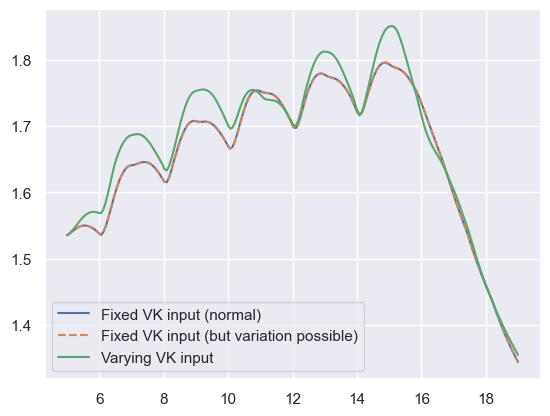

In [2]:
model, parameters_df = define_wajima_model(inr_test=True)
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in model.parameters()
])

doses = [5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1, 5, 1]
cal_time = 100 * 24
duration = 0.01
dose_rates = np.array(doses) / duration
regimen = myokit.Protocol()
for day, dr in enumerate(dose_rates):
    regimen.add(myokit.ProtocolEvent(
        level=dr,
        start=cal_time+day*24,
        duration=duration))
model.set_dosing_regimen(regimen)

times = np.linspace(5, 19, 200) * 24 + cal_time

sim = model.simulate(parameters, times)
sim2 = model.simulate(parameters, times, [1]*15)
sim3 = model.simulate(
    parameters, times, np.random.normal(loc=1, scale=0.1, size=15))

plt.plot(
    np.linspace(5, 19, 200), sim[0], label='Fixed VK input (normal)')
plt.plot(
    np.linspace(5, 19, 200), sim2[0], linestyle='--',
    label='Fixed VK input (but variation possible)')
plt.plot(
    np.linspace(5, 19, 200), sim3[0],
    label='Varying VK input')

plt.legend()
plt.show()

## Find distribution of maintenance doses across patients

1. Only measurement noise (i.e. no IIV, no IOV, no execution variability)

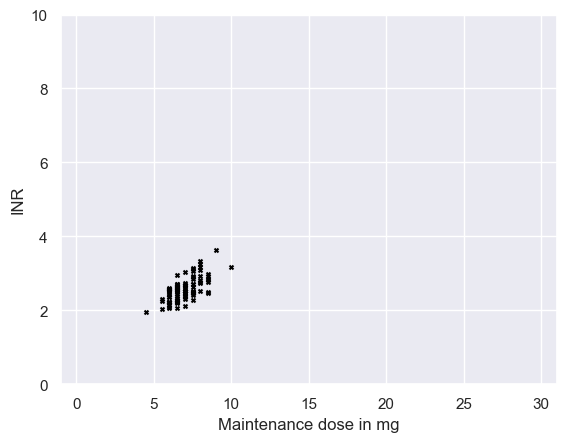

In [14]:
# Import distribution
directory = os.path.dirname(os.getcwd())
df = pd.read_csv(
    directory + '/data/S1_maintenance_distribution_only_noise.csv')

inrs = df[df.Observable == 'INR'].Value.dropna().values
doses = df.Dose.dropna().values

# Plot results
plt.scatter(doses, inrs, marker='x', color='black', s=8)
plt.xlim(([-1, 31]))
plt.ylim(([0, 10]))
plt.xlabel('Maintenance dose in mg')
plt.ylabel('INR')
plt.show()

2. Only execution variability (i.e. no IIV, no IOV, no measurement noise)

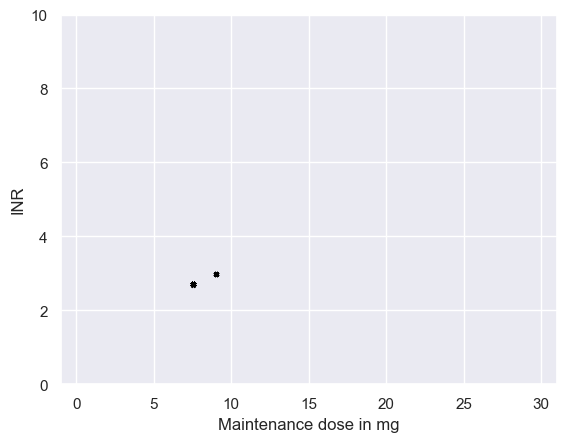

In [20]:
# Import distribution
directory = os.path.dirname(os.getcwd())
df = pd.read_csv(
    directory + '/data/S2_maintenance_distribution_only_EV.csv')

inrs = df[df.Observable == 'INR'].Value.dropna().values
doses = df.Dose.dropna().values

# Plot results
plt.scatter(doses, inrs, marker='x', color='black', s=8)
plt.xlim(([-1, 31]))
plt.ylim(([0, 10]))
plt.xlabel('Maintenance dose in mg')
plt.ylabel('INR')
plt.show()

Binary behaviour comes from binary adjustment criterion, i.e. inside or outside
TR. Without EV all doses are 7.5. Apparently EV leads occasionally to INRs
dropping below the TR, so maintenance dose is increased. This only happens
because the measurements are delayed. In principle, it is also possible that a
delayed administration from the previous day and a less delayed measurement on
the current leads to a decrease in the dose.

3. Only IOV (i.e. no IIV, no execution variability, no measurement noise)

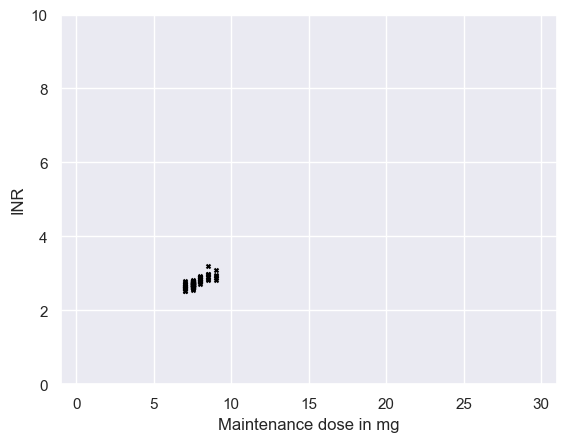

In [21]:
# Import distribution
directory = os.path.dirname(os.getcwd())
df = pd.read_csv(
    directory + '/data/S3_maintenance_distribution_only_IOV.csv')

inrs = df[df.Observable == 'INR'].Value.dropna().values
doses = df.Dose.dropna().values

# Plot results
plt.scatter(doses, inrs, marker='x', color='black', s=8)
plt.xlim(([-1, 31]))
plt.ylim(([0, 10]))
plt.xlabel('Maintenance dose in mg')
plt.ylabel('INR')
plt.show()

4. Only IIV (i.e. no IOV, no execution variability, no measurement noise)

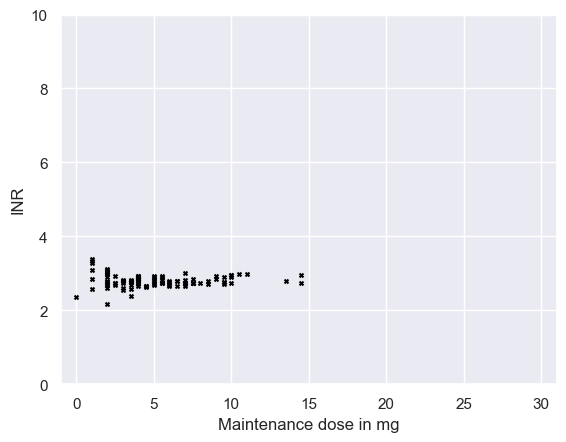

In [23]:
# Import distribution
directory = os.path.dirname(os.getcwd())
df = pd.read_csv(
    directory + '/data/S4_maintenance_distribution_only_IIV.csv')

inrs = df[df.Observable == 'INR'].Value.dropna().values
doses = df.Dose.dropna().values

# Plot results
plt.scatter(doses, inrs, marker='x', color='black', s=8)
plt.xlim(([-1, 31]))
plt.ylim(([0, 10]))
plt.xlabel('Maintenance dose in mg')
plt.ylabel('INR')
plt.show()

5. IIV and noise (i.e. no IOV, no execution variability)

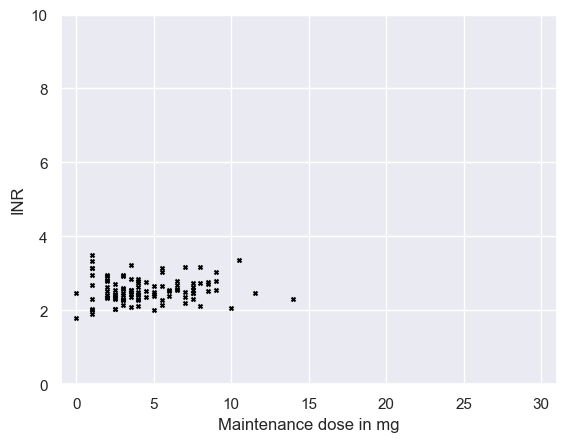

In [24]:
# Import distribution
directory = os.path.dirname(os.getcwd())
df = pd.read_csv(
    directory + '/data/S5_maintenance_distribution_IIV_noise.csv')

inrs = df[df.Observable == 'INR'].Value.dropna().values
doses = df.Dose.dropna().values

# Plot results
plt.scatter(doses, inrs, marker='x', color='black', s=8)
plt.xlim(([-1, 31]))
plt.ylim(([0, 10]))
plt.xlabel('Maintenance dose in mg')
plt.ylabel('INR')
plt.show()

6. IIV and IOV (i.e. no execution variability, no measurement noise)

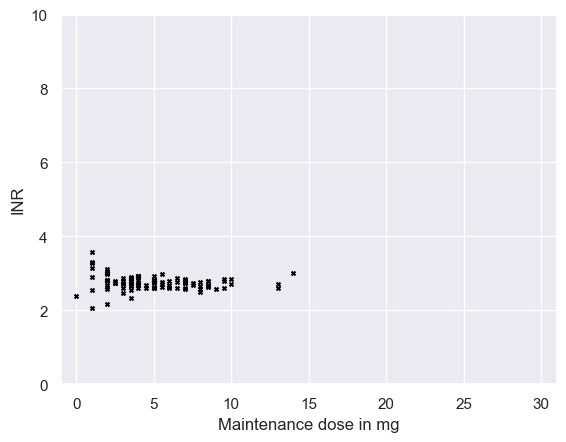

In [3]:
# Import distribution
directory = os.path.dirname(os.getcwd())
df = pd.read_csv(
    directory + '/data/S6_maintenance_distribution_IIV_IOV.csv')

inrs = df[df.Observable == 'INR'].Value.dropna().values
doses = df.Dose.dropna().values

# Plot results
plt.scatter(doses, inrs, marker='x', color='black', s=8)
plt.xlim(([-1, 31]))
plt.ylim(([0, 10]))
plt.xlabel('Maintenance dose in mg')
plt.ylabel('INR')
plt.show()

All components combined

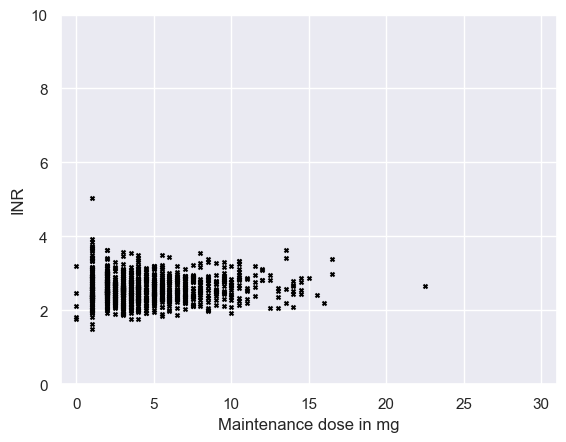

In [8]:
# Import distribution
directory = os.path.dirname(os.getcwd())
df = pd.read_csv(directory + '/data/trial_phase_III.csv')

inrs = df[df.Observable == 'INR'].Value.dropna().values
doses = df.Dose.dropna().values

# Plot results
plt.scatter(doses, inrs, marker='x', color='black', s=8)
plt.xlim(([-1, 31]))
plt.ylim(([0, 10]))
plt.xlabel('Maintenance dose in mg')
plt.ylabel('INR')
plt.show()

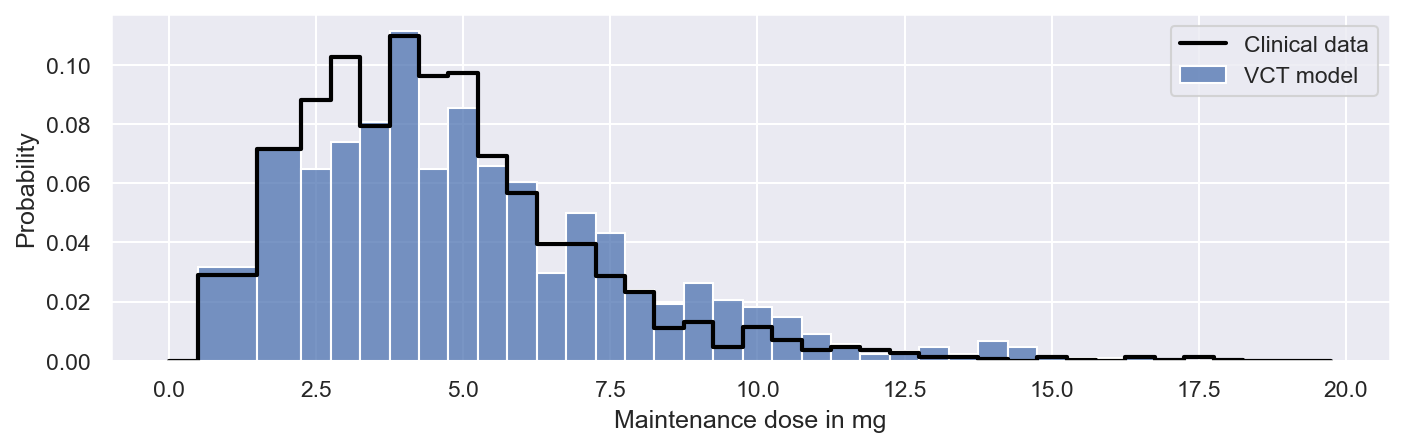

In [53]:
# Import clinical data
directory = os.path.dirname(os.getcwd())
df = pd.read_csv(
    directory + '/data/clinical_warfarin_inr_steady_state.csv',
    low_memory=False)
inrs = df[df.Observable == 'INR']
ids = inrs[(inrs.Value >= 2) & (inrs.Value <= 3)].ID.dropna().unique()
mask = df.ID == ids[0]
for _id in ids:
    mask = mask | (df.ID == _id)
clinical_doses = df[mask & (df.Time == 0)].Dose.dropna().values

# Load maintenance doses from trial III
df = pd.read_csv(directory + '/data/trial_phase_III.csv')
inrs = df[df.Observable == 'INR']
ids2 = inrs[(inrs.Value >= 2) & (inrs.Value <= 3)].ID.dropna().unique()
mask = df.ID == ids2[0]
for _id in ids2:
    mask = mask | (df.ID == _id)
doses = df[mask].Dose.dropna().values

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 1)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
sns.histplot(
        x=doses, ax=axes[0], fill=True,
        color=sns.color_palette()[0], stat='probability', legend=True,
        label='VCT model',
        bins=[
            0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
            6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75,
            11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25,
            15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75])
sns.histplot(
        x=clinical_doses, ax=axes[0], fill=False, element='step',
        color='black', stat='probability', legend=True, linewidth=2,
        label='Clinical data',
        bins=[
            0, 0.5, 1.5, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25, 5.75,
            6.25, 6.75, 7.25, 7.75, 8.25, 8.75, 9.25, 9.75, 10.25, 10.75,
            11.25, 11.75, 12.25, 12.75, 13.25, 13.75, 14.25, 14.75, 15.25,
            15.75, 16.25, 16.75, 17.25, 17.75, 18.25, 18.75, 19.25, 19.75])

# Label axes
axes[0].set_xlabel('Maintenance dose in mg')
axes[0].legend()

plt.savefig(
    'S3_maintenance_dose_distribution.pdf',
    bbox_inches='tight')
plt.savefig(
    'S3_maintenance_dose_distribution.tif',
    bbox_inches='tight')

plt.show()

In [54]:
len(ids)

2543

In [55]:
len(ids2)

880

## Baseline INR distribution

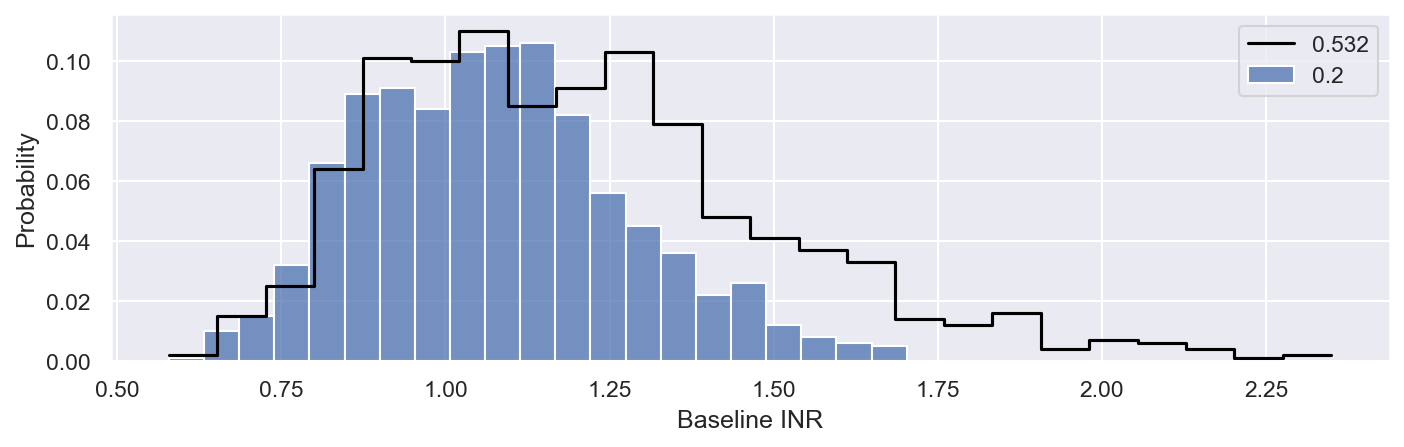

In [62]:
# Load baseline INR distribution
df = pd.read_csv(directory + '/data/S7_baseline_INR_distribution.csv')
inrs = df[(df.Observable == 'INR') & (df.Time == 480)].Value.values
typical = np.median(inrs)

# Load unmodified baseline INR distribution
df = pd.read_csv(
    directory + '/data/S7_baseline_INR_distribution_Hartmann_parameters.csv')
inrs2 = df[(df.Observable == 'INR') & (df.Time == 480)].Value.values
typical_original = np.median(inrs2)

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 1)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot time in therapeutic range
sns.histplot(
    x=inrs, ax=axes[0], fill=True,
    color=sns.color_palette()[0], stat='probability', legend=True,
    label='0.2')

sns.histplot(
    x=inrs2, ax=axes[0], fill=False, element='step',
    color='black', stat='probability', legend=True,
    label='0.532')

# axes[0].axvline(typical, color='blue', linestyle='dashed', linewidth=2)
# axes[0].axvline(
#     typical_original, color='black', linestyle='dashed', linewidth=2)

# Label axes
axes[0].set_xlabel('Baseline INR')
axes[0].legend()

plt.savefig(
    'S4_baseline_inr_distribution.pdf',
    bbox_inches='tight')
plt.savefig(
    'S4_baseline_inr_distribution.tif',
    bbox_inches='tight')

plt.show()

## Visualise VCT model components

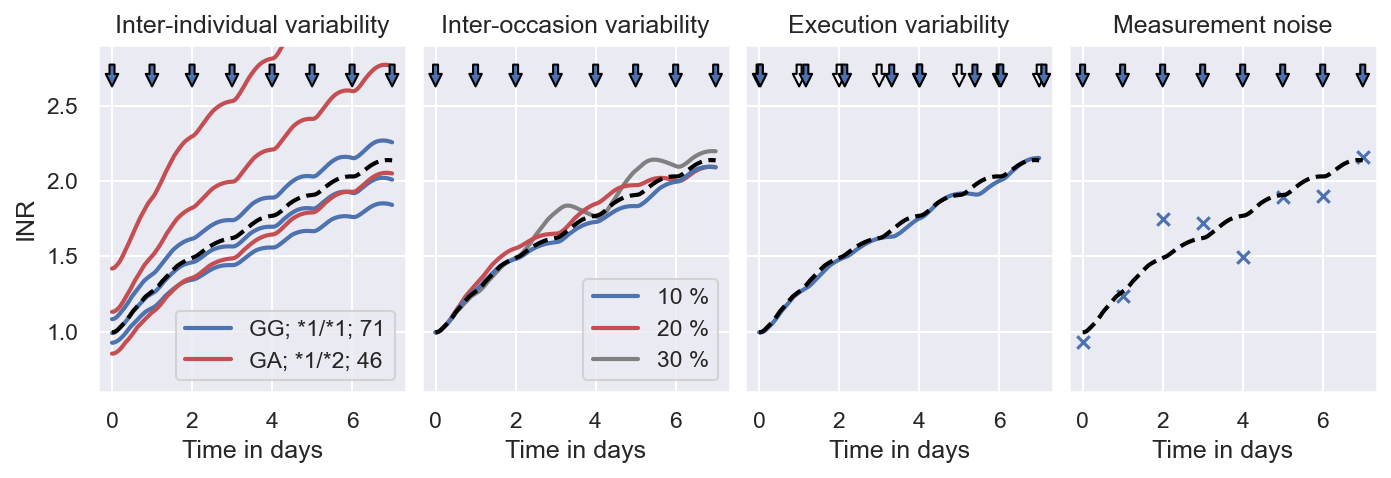

In [2]:
model, parameters_df = define_wajima_model(inr_test=True)
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in model.parameters()
])
pop_model, parameters_df = define_hartmann_population_model()
pop_params = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in pop_model.get_parameter_names()
])
pop_params_1 = pop_model.sample(
    pop_params, covariates=np.array([0, 0, 0, 71, 0]), n_samples=3, seed=1)

pop_params_2 = pop_model.sample(
    pop_params, covariates=np.array([1, 1, 1, 46, 1]), n_samples=3, seed=4)

cal_time = 100 * 24
doses = [10, 7.5, 5, 7, 7, 7, 7]
duration = 0.01
dose_rates = np.array(doses) / duration
regimen = myokit.Protocol()
for day, dr in enumerate(dose_rates):
    regimen.add(myokit.ProtocolEvent(
        level=dr,
        start=cal_time+day*24,
        duration=duration))
model.set_dosing_regimen(regimen)

times = np.linspace(0, 7, 200) * 24 + cal_time

# Simulate response
ref = model.simulate(parameters, times)[0]
rng = np.random.default_rng(seed=16)
vk1 = rng.normal(loc=1, scale=0.1, size=8)
vk2 = rng.normal(loc=1, scale=0.2, size=8)
vk3 = rng.normal(loc=1, scale=0.3, size=8)
error_model = chi.LogNormalErrorModel()
times_meas = np.arange(8)
meas = error_model.sample(
    parameters=[0.1],
    model_output=model.simulate(parameters, times_meas * 24 + cal_time)[0],
    seed=4)

# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 4, wspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

for idx, p in enumerate(pop_params_1):
    label = 'GG; *1/*1; 71' if idx == 0 else None
    sim = model.simulate(p, times)[0]
    axes[0].plot(
        (times - cal_time) / 24, sim, color=sns.color_palette()[0],
        linewidth=2, label=label)
for idx, p in enumerate(pop_params_2):
    label = 'GA; *1/*2; 46' if idx == 0 else None
    sim = model.simulate(p, times)[0]
    axes[0].plot(
        (times - cal_time) / 24, sim, color=sns.color_palette()[3],
        linewidth=2, label=label)

colors = [sns.color_palette()[0], sns.color_palette()[3], 'grey']
for idx, vk in enumerate([vk1, vk2, vk3]):
    label = f'{idx + 1}0 %'
    sim = model.simulate(parameters, times, vk)[0]
    axes[1].plot(
        (times - cal_time) / 24, sim, color=colors[idx],
        linewidth=2, label=label, zorder=10-idx)

delays = rng.exponential(scale=2.5, size=8)
regimen = myokit.Protocol()
for day, dr in enumerate(dose_rates):
    regimen.add(myokit.ProtocolEvent(
        level=dr,
        start=cal_time+day*24+delays[day],
        duration=duration))
model.set_dosing_regimen(regimen)
sim = model.simulate(parameters, times)[0]
axes[2].plot(
    (times - cal_time) / 24, sim, color=sns.color_palette()[0],
    linewidth=2)

axes[3].scatter(
    times_meas, meas, marker='x', color=sns.color_palette()[0],
    label='Measurement')

for ax in axes:
    ax.plot(
        (times - cal_time) / 24, ref, color='black', linestyle='--',
        linewidth=2, zorder=100)

# Visualise dosing regimen
for t in np.arange(8):
    for ax in [axes[0], axes[1], axes[-1]]:
        ax.annotate(
            "", xy=(t, 2.6), xytext=(t, 2.8),
            arrowprops=dict(arrowstyle="simple", edgecolor='black'))
for idt, t in enumerate(np.arange(8)):
    axes[2].annotate(
        "", xy=(t, 2.6), xytext=(t, 2.8),
        arrowprops=dict(
            arrowstyle="simple", edgecolor='black', facecolor='none'))
    axes[2].annotate(
        "", xy=(t + delays[idt] / 24, 2.6), xytext=(t + delays[idt] / 24, 2.8),
        arrowprops=dict(arrowstyle="simple", edgecolor='black'))

axes[0].set_ylabel('INR')
for ax in axes:
    ax.set_xlabel('Time in days')
    ax.set_ylim([0.6, 2.9])
for ax in axes[1:]:
    ax.set_ylabel('')
    ax.set_yticklabels(labels=[], visible=False)

axes[0].set_title('Inter-individual variability')
axes[1].set_title('Inter-occasion variability')
axes[2].set_title('Execution variability')
axes[3].set_title('Measurement noise')

axes[0].legend(loc='lower right')
axes[1].legend(loc='lower right')

plt.savefig(
    '2_warfarin_clinical_trial_model_components.pdf',
    bbox_inches='tight')
plt.savefig(
    '2_warfarin_clinical_trial_model_components.tif',
    bbox_inches='tight')

plt.show()

In [3]:
import networkx as nx

central.tissue_factor


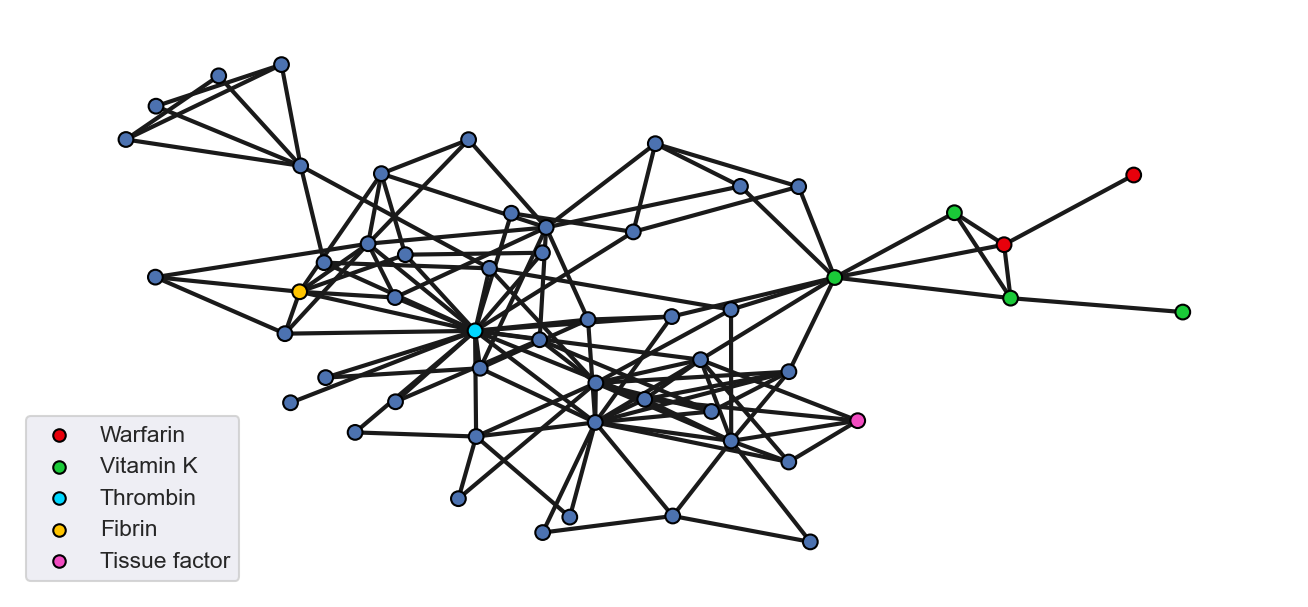

In [68]:
def remove_appendix(name):
    if '_amount' in name:
        return name[:-7]
    if '_concentration' in name:
        return name[:-14]
    return name

def get_name(state):
    name = remove_appendix(state.name())
    return state.parent().name() + '.' + name

def add_edge(name, state2, g):
    name2 = get_name(state2)
    valid_edge = \
        state2.is_intermediary() or state2.is_state()
    if valid_edge and (name != name2):
        g.add_edge(name, name2)


# Define graph
g = nx.Graph()

# Add nodes
for state in model._network_model._model.variables(state=True):
    g.add_node(get_name(state))
for state in model._network_model._model.variables(inter=True):
    if state.name() == 'vitamin_k_hydroquinone_concentration':
        test = state
    g.add_node(get_name(state))
# for state in model._network_model._model.variables(bound=True):
#     name = get_name(state)
#     if name == 'myokit.time':
#         continue
#     g.add_node(get_name(state))

for state in model._network_model._model.variables(state=True):
    name = get_name(state)
    for state2 in state.refs_by(state_refs=True):
        add_edge(name, state2, g)
    for state2 in state.refs_by(state_refs=False):
        add_edge(name, state2, g)
    for state2 in state.refs_to(state_refs=True):
        add_edge(name, state2, g)
    for state2 in state.refs_to(state_refs=False):
        add_edge(name, state2, g)
for state in model._network_model._model.variables(inter=True):
    name = get_name(state)
    for state2 in state.refs_by(state_refs=False):
        add_edge(name, state2, g)
    for state2 in state.refs_to(state_refs=True):
        add_edge(name, state2, g)
    for state2 in state.refs_to(state_refs=False):
        add_edge(name, state2, g)

pos = nx.nx_agraph.graphviz_layout(g)
nodes = sorted(g.nodes())
colors = [sns.color_palette()[0]] * len(nodes)
for idn, n in enumerate(nodes):
    if 'central.activated_coagulation_factor_ii' == n:
        colors[idn] = sns.color_palette('bright')[9]  # 'mediumorchid'
for idn, n in enumerate(nodes):
    if 'central.fibrin' == n:
        colors[idn] = sns.color_palette('bright')[8]  # 'lightcoral'
for idn, n in enumerate(nodes):
    if ('warfarin' in n) or ('drug' in n):
        colors[idn] = sns.color_palette('bright')[3]
for idn, n in enumerate(nodes):
    if ('vitamin_k' in n):
        colors[idn] = sns.color_palette('bright')[2]
for idn, n in enumerate(nodes):
    if n == 'central.tissue_factor':
        print(n)
        colors[idn] = sns.color_palette('bright')[6]  # 'lightgrey'
sizes = [50] * len(nodes)


# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 1)

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
for ax in axes:
    fig.add_subplot(ax)

nx.draw(
    g, pos, nodelist=nodes, node_size=sizes, node_color=colors, width=2,
    font_size=20, ax=axes[0], edgecolors=['black'] * len(n))

axes[0].scatter(
    [], [], color=sns.color_palette('bright')[3], label='Warfarin', edgecolor='black')
axes[0].scatter(
    [], [], color=sns.color_palette('bright')[2], label='Vitamin K', edgecolor='black')
axes[0].scatter(
    [], [], color=sns.color_palette('bright')[9], label='Thrombin', edgecolor='black')
axes[0].scatter(
    [], [], color=sns.color_palette('bright')[8], label='Fibrin', edgecolor='black')
axes[0].scatter(
    [], [], color=sns.color_palette('bright')[6], label='Tissue factor', edgecolor='black')
axes[0].legend()

plt.savefig(
    '2_wajima_coagulation_network_model.pdf',
    bbox_inches='tight')
plt.savefig(
    '2_wajima_coagulation_network_model.tif',
    bbox_inches='tight')

plt.show()

In [97]:
mechanistic_model, parameters_df = define_wajima_model()

# Prepare model for test
outputs = [
    'central.coagulation_factor_ii_concentration',
    'central.activated_coagulation_factor_ii_concentration',
    'central.coagulation_factor_x_concentration',
    'central.activated_coagulation_factor_x_concentration',
    'central.fibrinogen_concentration',
    'central.fibrin_concentration']
mechanistic_model.set_outputs(outputs)
parameters = np.array([
    parameters_df[parameters_df.Parameter == p].Value.values[0]
    for p in mechanistic_model.parameters()
])

# Dilute the plasma sample
n_states = mechanistic_model._n_states
parameters[:n_states] /= 3

# Set thrombomodulin concentration to zero
parameter_names = np.array(mechanistic_model.parameters())
index = np.where(parameter_names == 'central.thrombomodulin_amount')[0]
parameters[index] = 0

# Set endogenous production rates to zero
index = np.where(parameter_names == 'myokit.input_rate_vk')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_fibrinogen')[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.production_rate_plasminogen')[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.production_rate_prekrallikrein')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_tfpi')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_tmod')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_v')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_viii')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_xi')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_xii')[0]
parameters[index] = 0
index = np.where(parameter_names == 'myokit.production_rate_xiii')[0]
parameters[index] = 0

# Make sure that only compounds in central compartment are considered
index = np.where(parameter_names == 'dose.drug_amount')[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'peripheral_vitamin_k.vitamin_k_peripheral_amount'
)[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.transition_rate_vk_central_to_peripheral'
)[0]
parameters[index] = 0
index = np.where(
    parameter_names == 'myokit.transition_rate_vk_peripheral_to_central'
)[0]
parameters[index] = 0

# Change time units to seconds (for numerical stability)
indices = []
for idp, name in enumerate(parameter_names):
    if 'rate' in name:
        indices.append(idp)
parameters[indices] /= 60 * 60

# Add 300 nM tissue factor
index = np.where(parameter_names == 'central.size')[0]
volume = parameters[index]
index = np.where(parameter_names == 'central.tissue_factor_amount')[0]
parameters[index] = 300 * volume

# Ensure excess of coagulation factor VII (set to 10 nM)
index = np.where(
    parameter_names == 'central.caogaulation_factor_vii_amount')[0]
parameters[index] = 10 * volume

# Integrate fibrin concentration curve
times = np.linspace(start=0, stop=30, num=1000)
delta_time = (times[1] - times[0])
simulation = mechanistic_model.simulate(parameters, times)
fibrin_auc = np.cumsum(simulation[-1] * delta_time)

central.tissue_factor


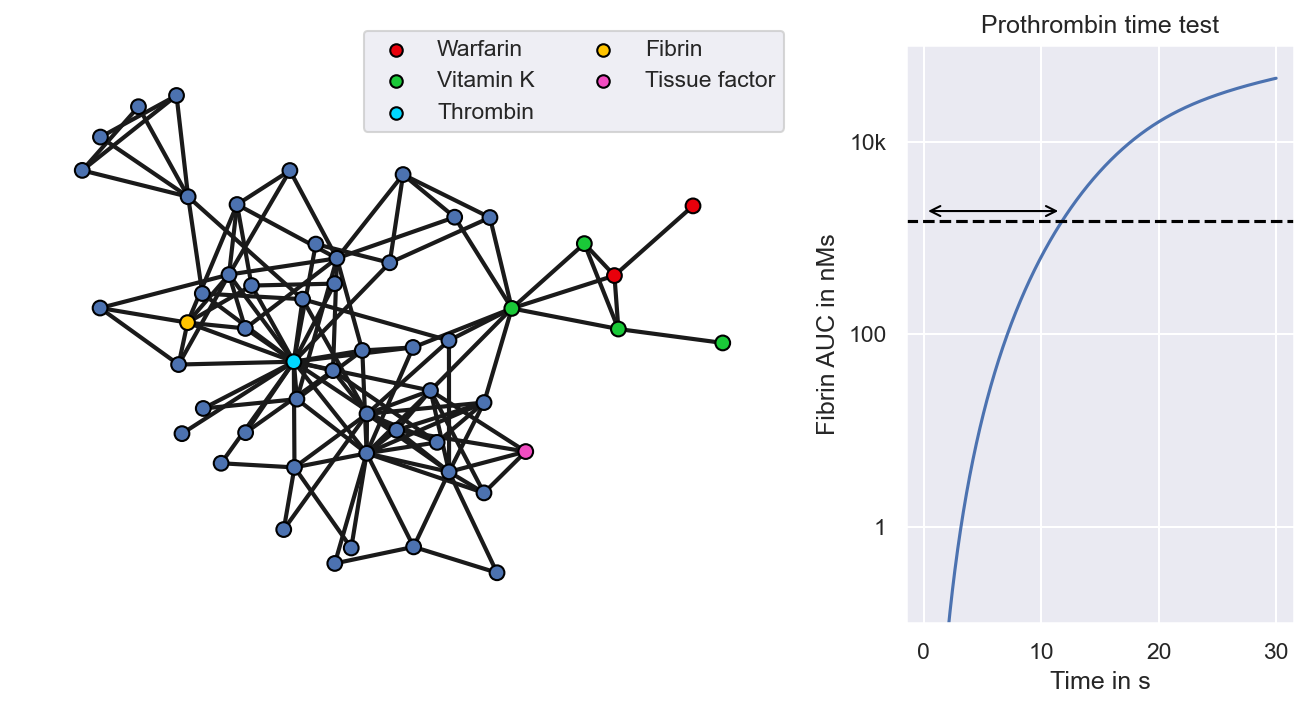

In [120]:
def remove_appendix(name):
    if '_amount' in name:
        return name[:-7]
    if '_concentration' in name:
        return name[:-14]
    return name

def get_name(state):
    name = remove_appendix(state.name())
    return state.parent().name() + '.' + name

def add_edge(name, state2, g):
    name2 = get_name(state2)
    valid_edge = \
        state2.is_intermediary() or state2.is_state()
    if valid_edge and (name != name2):
        g.add_edge(name, name2)


# Define graph
g = nx.Graph()

# Add nodes
for state in model._network_model._model.variables(state=True):
    g.add_node(get_name(state))
for state in model._network_model._model.variables(inter=True):
    if state.name() == 'vitamin_k_hydroquinone_concentration':
        test = state
    g.add_node(get_name(state))
# for state in model._network_model._model.variables(bound=True):
#     name = get_name(state)
#     if name == 'myokit.time':
#         continue
#     g.add_node(get_name(state))

for state in model._network_model._model.variables(state=True):
    name = get_name(state)
    for state2 in state.refs_by(state_refs=True):
        add_edge(name, state2, g)
    for state2 in state.refs_by(state_refs=False):
        add_edge(name, state2, g)
    for state2 in state.refs_to(state_refs=True):
        add_edge(name, state2, g)
    for state2 in state.refs_to(state_refs=False):
        add_edge(name, state2, g)
for state in model._network_model._model.variables(inter=True):
    name = get_name(state)
    for state2 in state.refs_by(state_refs=False):
        add_edge(name, state2, g)
    for state2 in state.refs_to(state_refs=True):
        add_edge(name, state2, g)
    for state2 in state.refs_to(state_refs=False):
        add_edge(name, state2, g)

pos = nx.nx_agraph.graphviz_layout(g)
nodes = sorted(g.nodes())
colors = [sns.color_palette()[0]] * len(nodes)
for idn, n in enumerate(nodes):
    if 'central.activated_coagulation_factor_ii' == n:
        colors[idn] = sns.color_palette('bright')[9]  # 'mediumorchid'
for idn, n in enumerate(nodes):
    if 'central.fibrin' == n:
        colors[idn] = sns.color_palette('bright')[8]  # 'lightcoral'
for idn, n in enumerate(nodes):
    if ('warfarin' in n) or ('drug' in n):
        colors[idn] = sns.color_palette('bright')[3]
for idn, n in enumerate(nodes):
    if ('vitamin_k' in n):
        colors[idn] = sns.color_palette('bright')[2]
for idn, n in enumerate(nodes):
    if n == 'central.tissue_factor':
        print(n)
        colors[idn] = sns.color_palette('bright')[6]  # 'lightgrey'
sizes = [50] * len(nodes)


# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, width_ratios=[2, 1])

# Create axes
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
for ax in axes:
    fig.add_subplot(ax)

nx.draw(
    g, pos, nodelist=nodes, node_size=sizes, node_color=colors, width=2,
    font_size=20, ax=axes[0], edgecolors=['black'] * len(n))

axes[0].scatter(
    [], [], color=sns.color_palette('bright')[3], label='Warfarin', edgecolor='black')
axes[0].scatter(
    [], [], color=sns.color_palette('bright')[2], label='Vitamin K', edgecolor='black')
axes[0].scatter(
    [], [], color=sns.color_palette('bright')[9], label='Thrombin', edgecolor='black')
axes[0].scatter(
    [], [], color=sns.color_palette('bright')[8], label='Fibrin', edgecolor='black')
axes[0].scatter(
    [], [], color=sns.color_palette('bright')[6], label='Tissue factor', edgecolor='black')
axes[0].legend(ncols=2, loc=[0.45, 0.85])

axes[1].set_title('Prothrombin time test')
axes[1].plot(times, fibrin_auc, color=sns.color_palette()[0])
axes[1].axhline(y=1500, color='black', linestyle='--')
axes[1].set_xlabel('Time in s')
axes[1].set_ylabel('Fibrin AUC in nMs')
axes[1].set_yscale('log')
axes[1].set_ylim([0.1, 1E5])
axes[1].set_yticks([1, 100, 10000])
axes[1].set_yticklabels(['1', '100', '10k'])

# axes[1].annotate(
#     "", xy=(0, 3E4), xytext=(0, 8E4),
#     arrowprops=dict(arrowstyle="simple", edgecolor='black'))
axes[1].annotate(
    "", xy=(0, 1900), xytext=(11.8, 1900),
    arrowprops=dict(arrowstyle="<->", edgecolor='black'))

plt.savefig(
    '2_wajima_coagulation_network_model.pdf',
    bbox_inches='tight')
plt.savefig(
    '2_wajima_coagulation_network_model.tif',
    bbox_inches='tight')

plt.show()